# Data ingestion and processing

In [15]:
import rasterio as rs 
from rasterio.windows import Window
from rasterio.transform import xy
from rasterio.vrt import WarpedVRT
from rasterio.crs import CRS
from rasterio.windows import Window

from pyproj import Transformer
import pandas as pd
from pandas import DataFrame
import geopandas as gpd
import numpy as np
from numpy import array,meshgrid,arange,log
from shapely import box


import ibis as ib
ib.options.interactive = True

In [5]:
# With dask

import dask as dk
import dask.array as da
import dask.dataframe as dd
# import dask_image as dki
import xarray as xr
import rioxarray as rx

from pyarrow import float16,float32,schema,field,uint16,table,Table
from pyarrow.parquet import ParquetWriter

In [3]:
# big file
src_file="/Users/cenv1069/Documents/data/datasets/JRC/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R8_C19/GHS_BUILT_C_MSZ_E2018_GLOBE_R2023A_54009_10_V1_0_R8_C19.tif"

# src_file = "/Users/cenv1069/Documents/data/datasets/JRC/S_10m/GHS_BUILT_S_NRES_E2018_GLOBE_R2023A_54009_10_V1_0_R8_C19/GHS_BUILT_S_NRES_E2018_GLOBE_R2023A_54009_10_V1_0_R8_C19.tif"

# src_file = "/Users/cenv1069/Documents/data/datasets/JRC/S_100m/GHS_BUILT_S_NRES_E2015_GLOBE_R2023A_54009_100_V1_0_R8_C19/GHS_BUILT_S_NRES_E2015_GLOBE_R2023A_54009_100_V1_0_R8_C19.tif"

# src_file = "Users/cenv1069/Documents/data/datasets/JRC/S_100m/GHS_BUILT_S_NRES_E2015_GLOBE_R2023A_54009_100_V1_0_R9_C19/GHS_BUILT_S_NRES_E2015_GLOBE_R2023A_54009_100_V1_0_R9_C19.tif"

# smaller size file
# src_file="/Users/cenv1069/Documents/data/datasets/JRC/S_1000m/GHS_BUILT_S_NRES_E2020_GLOBE_R2023A_54009_1000_V1_0_R8_C19/GHS_BUILT_S_NRES_E2020_GLOBE_R2023A_54009_1000_V1_0_R8_C19.tif"

## Working workflows below

In [ ]:
# inspired by : https://rasterio.readthedocs.io/en/stable/topics/virtual-warping.html

dst_crs = CRS.from_epsg(4326)
print(dst_crs)

In [ ]:
vrt_options = {
    # 'resampling': Resampling.cubic,
    'crs': dst_crs,
    # 'transform': dst_transform,
    # 'height': dst_height,
    # 'width': dst_width,
}

out_path = "test_med.parquet"

rast_schema = schema([('lon',float32())
                    ,('lat',float32())
                    ,('band_var',float32())
                    ])

rast_schema.with_metadata({
        "lon" : "Longitude coordinate",
        "lat" : "Latitude coordinate",
        "band_var" : "Value associated",
                            })


## Using a virtual Warper and windows

In [ ]:
%%time

with ParquetWriter(out_path, rast_schema) as writer:
    with rs.open(src_file) as src:
        
        src_crs = src.crs
        if len(src.nodatavals)>1:
            nodata = src.nodatavals[0]
        else :
            nodata = src.nodatavals

        print("No data value : ", nodata)
        print("Detected source crs : ", src_crs)

        with WarpedVRT(src, **vrt_options) as vrt:
            # At this point 'vrt' is a full dataset with dimensions,
            # CRS, and spatial extent matching 'vrt_options'.
            # Read all data into memory.
            # data = vrt.read()
            # Process the dataset in chunks.  Likely not very efficient.
            
            win_transfrom = vrt.window_transform

            for _, window in vrt.block_windows():
                # print(src.crs)
                band1 = vrt.read(window=window)
                
                height = band1.shape[1]
                width = band1.shape[2]
                cols, rows = meshgrid(arange(width), arange(height))

                xs, ys = xy(
                    transform = win_transfrom(window),
                    rows=rows,
                    cols=cols)

                lons = array(xs)
                lats = array(ys)
                
                out = DataFrame({"band_var" : array(band1).flatten()
                                        ,'lon': lons.flatten()
                                        ,'lat': lats.flatten()})
                
                out.drop(index=out.loc[out.band_var==nodata].index,inplace=True)
                out.drop(index=out.loc[out.band_var<=0].index,inplace=True)
                # print(out.shape)
                # print(out.head())

                if out.shape[0]!=0:
                    writer.write_table(Table.from_pandas(df=out,schema = rast_schema,preserve_index=False,safe=True))

            # # # Dump the aligned data into a new file.  A VRT representing
            # # # this transformation can also be produced by switching
            # # # to the VRT driver.
            # # directory, name = os.path.split(path)
            # # outfile = os.path.join(directory, 'aligned-{}'.format(name))
            # # rio_shutil.copy(vrt, outfile, driver='GTiff')

## Using a classic window approach

In [ ]:
# %%time

with ParquetWriter(out_path, rast_schema) as writer:
        with rs.open(src_file) as src:
            
            src_crs = src.crs
            win_transfrom = src.window_transform
            
            transformer = Transformer.from_crs(str(src_crs), 'EPSG:4326', always_xy=True)
            
            if len(src.nodatavals)>1:
                nodata = src.nodatavals[0]
            else :
                nodata = src.nodatavals

            print("No data value : ", nodata)
            print("Detected source crs : ", src_crs)
            
            # Process the dataset in chunks.  Likely not very efficient.
            for ij, window in src.block_windows():
                # print(window)
                # print(src.crs)
                band1 = src.read(window=window)
                # print(band1[0])
                height = band1.shape[1]
                width = band1.shape[2]
                cols, rows = meshgrid(arange(width), arange(height))
                # print(win_transfrom(window))
                xs, ys = xy(
                    transform = win_transfrom(window),
                    rows=rows,
                    cols=cols)
                
                # print(xs,ys)
                
                lons,lats = transformer.transform(array(xs),array(ys))
                # print(lons.shape)
                # print(lats.shape)
                # print(len(array(band1).flatten()))
                # print(len(lons.flatten()))
                
                out = DataFrame({'lon': lons.flatten(),
                                    'lat': lats.flatten(),
                                    "band_var" : array(band1[0,:,:]).flatten(),
                                    })
                
                out.drop(index=out.loc[out.band_var==nodata].index,inplace=True)
                out.drop(index=out.loc[out.band_var<=0].index,inplace=True)
                
                # print(out.shape)
                # print(out.head())
                
                if out.shape[0]!=0:
                        writer.write_table(Table.from_pandas(df=out,schema = rast_schema,preserve_index=False,safe=True))

In [17]:
test_data = ib.read_parquet(out_path)

In [ ]:
test_data.head()

In [ ]:
test_data.count()

In [ ]:
test_data.band_var.max()

In [19]:
# test_data.select("lon","lat")

In [20]:
# test_xy = test_data.select("lon","lat").to_pandas()


In [21]:
# gpd.GeoSeries(gpd.points_from_xy(test_xy["lon"],test_xy["lat"],crs="epsg:4326")).explore()

## Processing a huge file

In [ ]:
type((255,))==tuple

In [10]:
# using the module from the script
! python ../../src/scalenav/rast_converter.py /Users/cenv1069/Documents/data/datasets/JRC/S_100m/GHS_BUILT_S_NRES_E2015_GLOBE_R2023A_54009_100_V1_0_R8_C19/GHS_BUILT_S_NRES_E2015_GLOBE_R2023A_54009_100_V1_0_R8_C19.tif ../../test_big.parquet

Reading the following file(s):  /Users/cenv1069/Documents/data/datasets/JRC/S_100m/GHS_BUILT_S_NRES_E2015_GLOBE_R2023A_54009_100_V1_0_R8_C19/GHS_BUILT_S_NRES_E2015_GLOBE_R2023A_54009_100_V1_0_R8_C19.tif
No data value :  (65535.0,)
Detected source crs :  ESRI:54009


In [7]:
# using the module from the build package 
! python -m scalenav.rast_converter /Users/cenv1069/Documents/data/datasets/JRC/S_100m/GHS_BUILT_S_NRES_E2015_GLOBE_R2023A_54009_100_V1_0_R8_C19/GHS_BUILT_S_NRES_E2015_GLOBE_R2023A_54009_100_V1_0_R8_C19.tif ../../test_big.parquet

Reading the following file(s):  /Users/cenv1069/Documents/data/datasets/JRC/S_100m/GHS_BUILT_S_NRES_E2015_GLOBE_R2023A_54009_100_V1_0_R8_C19/GHS_BUILT_S_NRES_E2015_GLOBE_R2023A_54009_100_V1_0_R8_C19.tif
No data value :  (65535.0,)
Detected source crs :  ESRI:54009


## Reading a huge processed file

In [4]:
conn = ib.connect("duckdb://")

In [5]:
test_file = conn.read_parquet('../../H_AGBH_100.parquet')

In [6]:
test_file.band_var.min()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────┐
│ 0.000072 │
└──────────┘

In [7]:
test_file.head()

┏━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ lon       ┃ lat       ┃ band_var ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ float32   │ float32   │ float32  │
├───────────┼───────────┼──────────┤
│ 14.303575 │ 77.991524 │ 0.015588 │
│ 14.304570 │ 77.991524 │ 0.015588 │
│ 14.193995 │ 77.990524 │ 0.029040 │
│ 14.194992 │ 77.990524 │ 0.029040 │
│ 14.195988 │ 77.990524 │ 0.029040 │
└───────────┴───────────┴──────────┘

In [8]:
test_file.count()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┐
│ 526511828 │
└───────────┘

In [ ]:
# with rs.open("/Users/cenv1069/Documents/data/datasets/JRC/S_1000m/GHS_BUILT_S_NRES_E2020_GLOBE_R2023A_54009_1000_V1_0_R7_C22/GHS_BUILT_S_NRES_E2020_GLOBE_R2023A_54009_1000_V1_0_R7_C22.tif") as src:
#     # Process the dataset in chunks.  Likely not very efficient.
#     print(src.height)
#     print(src.width)
    
#     for ij, window in src.block_windows():
#         print((ij, window))



1000
1000
((0, 0), Window(col_off=0, row_off=0, width=256, height=256))
((0, 1), Window(col_off=256, row_off=0, width=256, height=256))
((0, 2), Window(col_off=512, row_off=0, width=256, height=256))
((0, 3), Window(col_off=768, row_off=0, width=232, height=256))
((1, 0), Window(col_off=0, row_off=256, width=256, height=256))
((1, 1), Window(col_off=256, row_off=256, width=256, height=256))
((1, 2), Window(col_off=512, row_off=256, width=256, height=256))
((1, 3), Window(col_off=768, row_off=256, width=232, height=256))
((2, 0), Window(col_off=0, row_off=512, width=256, height=256))
((2, 1), Window(col_off=256, row_off=512, width=256, height=256))
((2, 2), Window(col_off=512, row_off=512, width=256, height=256))
((2, 3), Window(col_off=768, row_off=512, width=232, height=256))
((3, 0), Window(col_off=0, row_off=768, width=256, height=232))
((3, 1), Window(col_off=256, row_off=768, width=256, height=232))
((3, 2), Window(col_off=512, row_off=768, width=256, height=232))
((3, 3), Window(

In [1]:
# import time
# from tqdm import tqdm
# from datetime import datetime

# def process_data():
#     # Simulate data processing loop
#     for _ in tqdm(range(100), desc="Processing data..."):
#         time.sleep(0.1)  # Simulating some processing time for each iteration

# def show_clock():
#     with tqdm(total=0, bar_format="{desc}", dynamic_ncols=True) as pbar:
#         while True:
#             # Get current time
#             now = datetime.now().strftime("%H:%M:%S")
#             # Update the tqdm bar with the current time
#             pbar.set_description(f"Clock: {now}")
#             time.sleep(1)  # Update every second


# # Run the clock in the background
# import threading
# clock_thread = threading.Thread(target=show_clock, daemon=True)
# clock_thread.start()

# # Run the data processing function
# process_data()

# # Optionally, wait for the clock thread to finish if needed
# clock_thread.join()

### Generating sample data sets

Let's select a window from which we want to sample, we can rely on the boundaries of the ghsl tiles for consistency and ease : 

In [14]:
ghsl_tile_bounds = {"R8_C19" : [-0.419440,8.098056,9.778591,16.259129]}

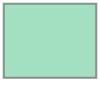

In [50]:

box_window = box(*ghsl_tile_bounds["R8_C19"],ccw=False)
box_window

In [51]:
# 
src_nc = "/Users/cenv1069/Documents/data/datasets/kummu_etal/pedigree_HDI_1990_2015_v2.nc"
out_file = "../../data/test_data_1.tif"

In [1]:
# with rs.open(src_nc) as src:
#     print(src.bounds)
#     print(src.shape)

#     out_image, out_transform = rs.mask.mask(src, [box_window], crop=True)
#     out_meta = src.meta
#     # print(out_meta)
#     if len(out_image)>2:
#         out_image = out_image[out_image.shape[0]-1]

#     out_meta.update({"driver": "GTiff",
#                     "height": out_image.shape[0],
#                     "width": out_image.shape[1],
#                     'crs': "epsg:4326",
#                     "transform": out_transform})

#     with rs.open(out_file, "w", **out_meta) as dest:
#         dest.write(out_image)

In [ ]:
# with rs.open(out_file) as src:
#     print(src.shape)


NameError: name 'rs' is not defined

In [54]:
from scalenav.rast_converter import rast_converter

In [55]:
rast_converter(in_path="../../data/test_data_1.tif")

Reading the following file(s):  ../../data/test_data_1.tif
No data value :  -9.0
Detected source crs :  EPSG:4326


In [56]:
rast_convert = pd.read_parquet("rast_convert.parquet")
print(rast_convert.shape)
rast_convert.head()

(122, 3)


,lon,lat,band_var
0,-0.375000,8.125,4.0
1,-0.291667,8.125,4.0
2,-0.208333,8.125,4.0
3,-0.125000,8.125,4.0
4,-0.041667,8.125,4.0


In [57]:
gpd.GeoSeries.from_xy(rast_convert["lon"],rast_convert["lat"],crs="epsg:4326").explore()